# Fitness Tracker Survival Analysis
Created by: Andy Luc

## Business case:
1. What is the average amount of time that MyFitnessPal users use the app, and do they use it consistently throughout?
2. Do users still keep using the program after meeting or not meeting their goal?

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from datetime import date, datetime
plt.style.use('seaborn')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis

In [ ]:
# Reading the data file
data = pd.read_csv('data/mfp-diaries.tsv',
                  sep='\t',
                  header=None,
                  names=['userid','diary_date','food_entries','daily_goal'])

In [ ]:
data.head()

In [ ]:
# Number of unique users
len(data['userid'].unique())

### Pickled files:
To save processing time when loading into dataframe.

In [ ]:
# total_goal.to_pickle('total_goal.pkl')
# total_goal.to_pickle('end_date.pkl')
# final_churn.to_pickle('final_churn.pkl')
# df.to_pickle('df.pkl')

### Setting up dataframe for Survival Analysis
Since we are concerned with when a user decides to stop using the MyFitnessPal program based on their input attributes, I am going to focus on the *diary_date* and *daily_goal* columns. First, we need to parse the nested dictionary within the daily_goal column.

In [ ]:
# Parsing only the dialy_goals column
mark = data.drop(['userid', 'diary_date','food_entries'], axis=1)

In [ ]:
# Loading into json format for extraction
target = json.loads(goals['daily_goal'][0])
target

In [ ]:
"""Creates list of keys and values from the first dictionary, and zips them together"""
def daily_totals(target):    
    total_cols = [list(target.keys())[0] + "_" + x['name'].lower() 
                  for x in target['total']]
    total_values = [y['value'] 
                  for y in target['total']]

    total_dict = {}
    for col, val in zip(total_cols, total_values):
        total_dict[col] = val
    return total_dict

"""Creates list of keys and values from the second dictionary, and zips them together"""
def daily_goals(target):
    goal_cols = [list(target.keys())[1] + "_" + k['name'].lower()
                 for k in target['goal']]
    goal_values = [i['value']
                 for i in target['goal']]
    
    goal_dict = {}
    for col, val in zip(goal_cols, goal_values):
        goal_dict[col] = val
    return goal_dict

"""Combines new keys and values for 'Total' and 'Goals' into single dictionary"""
def merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res

"""Iterrates through entire parsed dataframe and appends merged rows"""
def parsed_dict():
    results = []
    for row in mark['daily_goal'].values:
        target = json.loads(row)
        results.append(merge(daily_goals(target), daily_totals(target)))
    return results

In [ ]:
# Putting it back into a pandas dataframe
new_mark = pd.DataFrame(parsed_dict())
new_mark.head()

In [ ]:
# Merging the original dataframe with the newly parsed daily_goal column
con = pd.concat([data, new_mark], axis=1)

In [ ]:
# Looking at the number of null values for each column
con.isna().sum()

In [ ]:
# Dropping columns which have high null values which are not beneficial to the features being used
total_goal = con.drop(['food_entries','daily_goal','goal_calcium','goal_chol',
                       'goal_iron','goal_mon fat','goal_ply fat','goal_potass.',
                       'goal_sat fat','goal_trn fat','goal_vit a','goal_vit c',
                       'total_calcium','total_chol','total_iron','total_mon fat',
                       'total_ply fat','total_potass.','total_sat fat','total_trn fat',
                       'total_vit a','total_vit c'], axis=1)

In [ ]:
# Fill the remaining null values of each nutrient with 0
total_goal.fillna(0, inplace=True)

In [ ]:
# Changing diary_date column to a datetime type
total_goal['diary_date'] = pd.to_datetime(total_goal['diary_date'])

### Create 1 column per dictionary in both total key and goal key

- total
    + total_calories
    + total_carbs
    + total_fat
    + total_fiber
    + total_protein
    + total_sodium
    + total_sugar
- goal
    + goal_calories
    + goal_carbs
    + goal_fat
    + goal_fiber
    + goal_protein
    + goal_sodium
    + goal_sugar


Add additional columns:
- **total_sum**: Total sum of input values for the day
- **goal_sum**: Total sum of goal values for the day
- **achievement**: Indicates whether or not a user has met their daily goal within a tolerance of 10%.
    - 1 = Succeed
    - 0 = Fail

In [ ]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

total_s = []
goal_s = []
for nutrient in nutrients:
    total_s.append(f'total_{nutrient}')
    goal_s.append(f'goal_{nutrient}')

total_goal['total_sum'] = total_goal[total_s].apply(np.sum, axis=1)

total_goal['goal_sum'] = total_goal[goal_s].apply(np.sum, axis=1)

total_goal['achievement'] = np.where(abs((total_goal['total_sum'] - 
                                          total_goal['goal_sum']) / 
                                          total_goal['goal_sum']) <= 0.1, 1, 0)

In [ ]:
coll = total_goal.drop(['userid','diary_date','goal_calories','goal_carbs',
                        'goal_fat','goal_fiber','goal_protein','goal_sodium',
                        'goal_sugar','total_sum','goal_sum'], axis=1)

### Create Multi-Collinearity Heatmap
This is just to show if any columns have collinear values. We would essentially drop a certain column if the value they are highly correlated, but in this case we want to keep the features as they may pertain to the survival analysis model. As you can see sugar and carbs are correlated, which we can say is a true statement.

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(coll.corr(), center=0, cmap='BrBG', annot=True)

ax.set_title('Multi-Collinearity of Attributes')

## Survival Analysis
Min & Max Diary Dates: Sept 14, 2014 - Apr 9, 2015
1. duration_col = length of time between start date and time of churn
2. event_col = time of churn (when there is a break >=10 days)
    * churn = 1
    * continuous = 0

In [ ]:
for index, row in total_goal.iterrows():
    if (index != len(total_goal) - 1):
        total_goal.loc[index, 'end_date'] = total_goal.loc[index + 1, 'diary_date']

In [2]:
total_goal = pd.read_pickle('end_date.pkl')

In [4]:
user1 = total_goal[total_goal['userid'] == 3]
user1

,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
234,3,2014-09-14,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,2270.0,45.0,15.0,3.0,16.0,810.0,0.0,3159.0,3786.0,0,2014-09-15
235,3,2014-09-15,1348.0,168.0,45.0,28.0,67.0,2300.0,0.0,1628.0,122.0,61.0,30.0,76.0,1564.0,0.0,3481.0,3956.0,0,2014-09-16
236,3,2014-09-16,1486.0,185.0,49.0,31.0,74.0,2300.0,0.0,1468.0,158.0,41.0,15.0,55.0,1588.0,0.0,3325.0,4125.0,0,2014-09-17
237,3,2014-09-17,1487.0,186.0,49.0,31.0,74.0,2300.0,0.0,1405.0,174.0,48.0,16.0,63.0,2157.0,0.0,3863.0,4127.0,1,2014-09-18
238,3,2014-09-18,1487.0,186.0,49.0,31.0,74.0,2300.0,0.0,1790.0,139.0,72.0,45.0,79.0,2330.0,0.0,4455.0,4127.0,1,2014-09-19
239,3,2014-09-19,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,2200.0,0.0,0.0,0.0,0.0,0.0,0.0,2200.0,3786.0,0,2014-09-23
240,3,2014-09-23,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,1208.0,173.0,30.0,11.0,34.0,1707.0,0.0,3163.0,3786.0,0,2014-10-21


In [5]:
total_goal.loc[0, 'end_date'] - total_goal.loc[0, 'diary_date']

Timedelta('1 days 00:00:00')

In [6]:
prev_user = ''
start_date = None
churn_date = None
churned = False

prev_user = total_goal.loc[0, 'userid']
start_date = total_goal.loc[0, 'diary_date']

result = []
for index, row in total_goal.iterrows():
#     if index == 0:
#         continue
#     if index == 500:
#         break
        
    user = row['userid']
    if prev_user == user:
        # Same user check churn date
        if (row['end_date'] - row['diary_date']) >= pd.Timedelta(5, 'D'):
            if not churned:
                churn_date = row['diary_date']
                record = {'userid':user, 
                          'start_date': start_date,
                          'churn_date': churn_date}
                result.append(record)
                churned = True        
    else:
        # Diff user
        if not churned:
            record = {'userid':prev_user, 
                      'start_date': start_date,
                      'churn_date': ''}
            result.append(record)
        start_date = row['diary_date']
        churned = False
        
    prev_user = user

In [120]:
end_date = pd.DataFrame(result)
end_date.head()

,churn_date,start_date,userid
0,2014-11-01,2014-09-14,1
1,NaT,2015-01-12,2
2,2014-09-23,2014-09-14,3
3,2014-10-22,2014-10-21,4
4,NaT,2014-09-14,5


In [121]:
end_date['days'] = (end_date['churn_date'] - end_date['start_date']).dt.days

end_date.head()

,churn_date,start_date,userid,days
0,2014-11-01,2014-09-14,1,48.0
1,NaT,2015-01-12,2,NaN
2,2014-09-23,2014-09-14,3,9.0
3,2014-10-22,2014-10-21,4,1.0
4,NaT,2014-09-14,5,NaN


In [122]:
end_date['churn_5days'] = end_date['churn_date'].apply(lambda x: 0 if type(x) is not pd.Timestamp else 1)

end_date.head()

,churn_date,start_date,userid,days,churn_5days
0,2014-11-01,2014-09-14,1,48.0,1
1,NaT,2015-01-12,2,NaN,0
2,2014-09-23,2014-09-14,3,9.0,1
3,2014-10-22,2014-10-21,4,1.0,1
4,NaT,2014-09-14,5,NaN,0


In [124]:
days_count = total_goal['userid'].value_counts().sort_index()
days_count = pd.DataFrame(days_count).rename(columns={'userid': 'days_count'})
days_count.head()

,days_count
1,174
2,60
3,7
4,27
5,179


In [128]:
final_churn = pd.merge(days_count, end_date, left_index=True, right_on='userid')
final_churn.index = final_churn['userid']
final_churn = final_churn.drop('userid', axis=1)

In [131]:
final_churn.head()

,days_count,churn_date,start_date,userid,days,churn_5days
userid,,,,,,
1,174,2014-11-01,2014-09-14,1,48.0,1
2,60,NaT,2015-01-12,2,NaN,0
3,7,2014-09-23,2014-09-14,3,9.0,1
4,27,2014-10-22,2014-10-21,4,1.0,1
5,179,NaT,2014-09-14,5,NaN,0


In [132]:
final_churn.days.fillna(final_churn.days_count, inplace=True)

final_churn.head()

,days_count,churn_date,start_date,userid,days,churn_5days
userid,,,,,,
1,174,2014-11-01,2014-09-14,1,48.0,1
2,60,NaT,2015-01-12,2,60.0,0
3,7,2014-09-23,2014-09-14,3,9.0,1
4,27,2014-10-22,2014-10-21,4,1.0,1
5,179,NaT,2014-09-14,5,179.0,0


### Exploratory Analysis with final churn dataframe

In [157]:
user = total_goal[total_goal['userid'] == 3]

print(user.diary_date.diff().value_counts())
print('\n')
print(user.diary_date.value_counts().sum())

user[user.diary_date.diff() > pd.Timedelta(3, 'D')]

1 days    5
4 days    1
Name: diary_date, dtype: int64


7


,userid,diary_date,goal_calories,goal_carbs,goal_fat,goal_fiber,goal_protein,goal_sodium,goal_sugar,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement,end_date
240,3,2014-09-23,1210.0,151.0,40.0,25.0,60.0,2300.0,0.0,1208.0,173.0,30.0,11.0,34.0,1707.0,0.0,3163.0,3786.0,0,2014-10-21


### Merging "final_churn" and "total_goal" dataframes

In [160]:
cols = total_goal.drop(['userid','diary_date'], axis=1).columns

condense = total_goal.groupby(['userid'])[cols].sum()

unite = pd.merge(final_churn, condense, left_index=True, right_index=True)

In [161]:
unite.head()

,days_count,churn_date,start_date,userid,days,churn_5days,goal_calories,goal_carbs,goal_fat,goal_fiber,...,total_calories,total_carbs,total_fat,total_fiber,total_protein,total_sodium,total_sugar,total_sum,goal_sum,achievement
userid,,,,,,,,,,,,,,,,,,,,,
1,174,2014-11-01,2014-09-14,1,48.0,1,375085.0,46633.0,12472.0,0.0,...,401750.0,32265.0,13562.0,0.0,22408.0,360487.0,14227.0,844699.0,867495.0,68
2,60,NaT,2015-01-12,2,60.0,0,90925.0,11387.0,2955.0,0.0,...,87430.0,10872.0,2537.0,0.0,2550.0,100217.0,4573.0,208179.0,251403.0,11
3,7,2014-09-23,2014-09-14,3,9.0,1,9438.0,1178.0,312.0,196.0,...,11969.0,811.0,267.0,120.0,323.0,10156.0,0.0,23646.0,27693.0,2
4,27,2014-10-22,2014-10-21,4,1.0,1,44211.0,5524.0,1464.0,0.0,...,24636.0,2682.0,1001.0,0.0,1153.0,40061.0,0.0,69533.0,115522.0,4
5,179,NaT,2014-09-14,5,179.0,0,572414.0,0.0,15948.0,7564.0,...,536631.0,0.0,13818.0,6305.0,33720.0,358700.0,21707.0,970881.0,1064788.0,58


In [162]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = unite[f'total_{nutrient}']
    goal = unite[f'goal_{nutrient}']
    unite[f'{nutrient}_10_pct'] = np.where(abs((total - goal) / goal) <= 0.1, 1, 0)

In [166]:
unite.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


In [170]:
unite.drop(unite.columns.difference(['days','churn_5days','achievement','calories_10_pct',
                                          'carbs_10_pct','fat_10_pct','fiber_10_pct','protein_10_pct',
                                          'sodium_10_pct','sugar_10_pct']), 1, inplace=True)

In [173]:
df = unite
df.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9896 entries, 1 to 9897
Data columns (total 10 columns):
days               9896 non-null float64
churn_5days        9896 non-null int64
achievement        9896 non-null int64
calories_10_pct    9896 non-null int64
carbs_10_pct       9896 non-null int64
fat_10_pct         9896 non-null int64
fiber_10_pct       9896 non-null int64
protein_10_pct     9896 non-null int64
sodium_10_pct      9896 non-null int64
sugar_10_pct       9896 non-null int64
dtypes: float64(1), int64(9)
memory usage: 850.4 KB


### 5 day Churn:

In [3]:
from lifelines import CoxPHFitter, KaplanMeierFitter

In [4]:
df.head()

,days,churn_5days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,,
1,48.0,1,68,1,0,1,0,0,1,1
2,60.0,0,11,1,1,0,0,0,0,0
3,9.0,1,2,0,0,0,0,0,0,0
4,1.0,1,4,0,0,0,0,0,0,0
5,179.0,0,58,1,0,0,0,1,0,1


In [5]:
cph = CoxPHFitter()
five_days = cph.fit(df, duration_col='days', event_col='churn_5days')
five_days.print_summary()

<lifelines.CoxPHFitter: fitted with 9896 observations, 2789 censored>
      duration col = 'days'
         event col = 'churn_5days'
number of subjects = 9896
  number of events = 7107
partial log-likelihood = -58751.44
  time fit was run = 2019-07-02 21:39:09 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.04      0.96      0.00 -36.46 <0.005    964.51       -0.04       -0.03
calories_10_pct -0.02      0.98      0.04  -0.51   0.61      0.71       -0.09        0.05
carbs_10_pct     0.06      1.07      0.04   1.68   0.09      3.42       -0.01        0.14
fat_10_pct       0.13      1.14      0.03   4.18 <0.005     15.07        0.07        0.19
fiber_10_pct     0.15      1.16      0.08   1.91   0.06      4.17       -0.00        0.31
protein_10_pct  -0.13      0.88      0.05  -2.79   0.01      7.56       -0.22       -0.04
sodium_10_pct    0.10      1.11      0.04   2.56   0.01      6.59        0.02        0.18
sugar_10_p

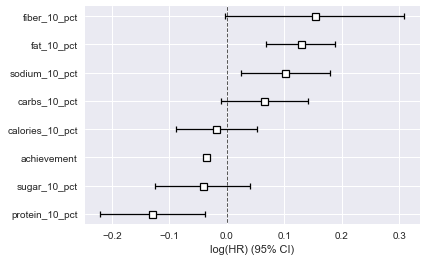

In [6]:
five_days.plot()

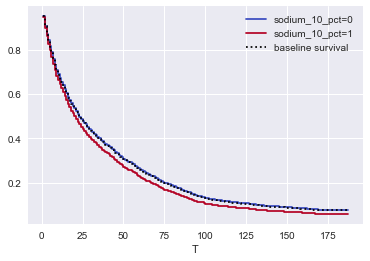

In [49]:
cph.plot_covariate_groups('sodium_10_pct', [0, 1], cmap='coolwarm')

y-axis = risk
at 25 days, there is a lower risk of churning based only on meeting sodium goals

## Logistic Regression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report

In [12]:
#Setting X and y variables, then Train Test Split
X = df.drop('churn_5days', axis=1)
y = df.churn_5days

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [13]:
loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
loreg.fit(X_train, y_train)
loreg_preds = loreg.predict(X_test)

In [14]:
def print_metrics(y, loreg_preds):
    print("Precision Score: {}".format(precision_score(y, loreg_preds)))
    print("Recall Score: {}".format(recall_score(y, loreg_preds)))
    print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
    print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
print_metrics(y_test, loreg_preds)

Precision Score: 0.7763888888888889
Recall Score: 0.9469226425748165
Accuracy Score: 0.7667744543249798
F1 Score: 0.8532180106843044


In [21]:
print(classification_report(y_test, loreg_preds))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43       703
           1       0.78      0.95      0.85      1771

   micro avg       0.77      0.77      0.77      2474
   macro avg       0.74      0.63      0.64      2474
weighted avg       0.75      0.77      0.73      2474



In [25]:
X_train.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct
userid,,,,,,,,,
4883,3.0,4,0,0,0,0,0,0,0
1448,179.0,98,1,0,0,0,0,0,0
4705,37.0,10,0,1,0,0,0,0,0
5601,24.0,32,1,0,1,0,0,1,0
3120,179.0,34,0,1,1,0,0,0,0


In [43]:
m = np.array((60, 11, 1, 1, 0, 0, 0, 0, 0))
m_df = pd.DataFrame(m).T
m_df

,0,1,2,3,4,5,6,7,8
0,60,11,1,1,0,0,0,0,0


In [44]:
loreg.predict(m_df)

array([1])

## Time Series Analysis

In [ ]:
total_goal_df.head()

In [ ]:
irrelevant = ['goal_calories','goal_carbs','goal_fat','goal_fiber','goal_protein',
              'goal_sodium','goal_sugar','total_calories','total_carbs','total_fat',
              'total_fiber','total_protein','total_sodium','total_sugar','achievement']

time_df = total_goal_df.drop(irrelevant, axis=1)

In [ ]:
time_df.head()

In [ ]:
time_df['tg_diff'] = round(abs((time_df['total_sum'] - time_df['goal_sum'])/time_df['goal_sum']), 3)

In [ ]:
# time_df['tg_diff'] = pd.Series(["{0:.2f}%".format(val * 100) for val in time_df['tg_diff']])

In [ ]:
time_df = time_df.drop(['total_sum','goal_sum'], axis=1)

In [ ]:
time_df.set_index('diary_date', inplace=True)

In [ ]:
time_df.head()

In [ ]:
new_time_df = pd.DataFrame(time_df[(time_df['userid']==1)|(time_df['userid']==2)])

In [ ]:
new_time_df.head()

In [ ]:
by_label = new_time_df.groupby('userid')

for name, group in by_label:
    plt.plot(group['tg_diff'], label=name)

plt.legend()
plt.show()

In [ ]:
# json_dict.keys()[0]
# Gives Error: 'dict_keys' object does not support indexing, hence needs to be set to a list to iterate.

In [ ]:
# df = pd.DataFrame([[1, 4],
#                    [2, 5],
#                    [3, 6]],
#                   columns=["a", "b"])
# df

In [ ]:
# df["c"] = df.apply(np.sum, axis=1)
# df

## K Means Clustering

In [ ]:
survival_per_day = pd.read_pickle('survival_per_day.pkl')

In [ ]:
survival_per_day.head()

In [ ]:
survival_per_day = survival_per_day.drop(['days','achievement'], axis=1)

In [ ]:
cluster_df = survival_per_day

In [ ]:
cluster_df.head()

In [ ]:
combine_df = combine_df.drop(['achievement'],axis=1)

In [ ]:
combine_df.head()

In [ ]:
combine_df['achievement'] = np.where(abs((combine_df['total_sum'] - 
                                          combine_df['goal_sum']) / 
                                          combine_df['goal_sum']) <= 0.1, 1, 0)
combine_df.head()

In [ ]:
combine_df = combine_df.drop(['goal_calories','goal_carbs','goal_fat','goal_fiber','goal_protein',
                              'goal_sodium','goal_sugar','total_calories','total_carbs','total_fat',
                              'total_fiber','total_protein','total_sodium','total_sugar','total_sum','goal_sum'],
                             axis=1)

In [ ]:
combine_df.head()

In [ ]:
cluster_log = pd.merge(cluster_df, combine_df, left_index=True, right_index=True)

In [ ]:
cluster_log.head()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
cluster_log.head()

In [ ]:
cluster_log = cluster_log.drop(['days'], axis=1)

In [ ]:
cluster_log.head()

In [ ]:
ss = StandardScaler()
scaled_data = ss.fit_transform(cluster_log.astype(float))

In [ ]:
scaled_df=pd.DataFrame(data=scaled_data, columns=cluster_log.columns)
scaled_df.head()

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(data=pca_data, columns=['pca1', 'pca2'])
pca_df.head()

In [ ]:
X = scaled_data
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    
plt.figure(figsize=(10,5))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.grid(True)

In [ ]:
model = KMeans(n_clusters=4, random_state=10).fit(pca_df)
model_label = model.labels_
model_centers = model.cluster_centers_
sorted(model_centers.tolist())

In [ ]:
plt.figure(figsize=(10,8))

plt.title('K-Means Clustering')
plt.xlabel('pca1')
plt.ylabel('pca2')

scatter = plt.scatter(pca_df['pca1'], pca_df['pca2'], c=model_label, s=25, cmap='RdBu_r')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='*');

In [ ]:
pca_components = pd.DataFrame(pca.components_, columns=cluster_log.columns)
pca_components.head()

In [ ]:
# Limits only rows with userid's with greater than 2 days of inputs

# counts = total_goal['userid'].value_counts()
# s_res = total_goal[~total_goal['userid'].isin(counts[counts <= 2].index)]
# s_res['userid'].value_counts().tail()